In [60]:
import os
import pandas as pd
import numpy as np
import gradio as gr
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
import cv2
import numpy as np
from PIL import Image, ImageFilter
import pickle

from glob import glob
#import matplotlib.pyplot as plt
import joblib
import imgaug.augmenters as iaa




In [2]:
RF_output_file = "Output/everything-val_pred_HC_pixel_sz.csv"
os.path.exists(RF_output_file)


True

In [3]:
## note I output all data in to a CSV everything-val_pred_HC_pixel_sz.csv, sep '|'

import pandas as pd

# Read the CSV file into a DataFrame
RF_Output_df = pd.read_csv(RF_output_file, sep=',')




In [10]:
rf_model_a_path = "Modelfile/rf_Arfaa_jun16.pkl"
os.path.exists(rf_mode_a_path)

False

In [14]:
# Load the RF model
with open(rf_model_a_path, 'rb') as file:
    rf_model_a = pickle.load(file)



In [47]:
# Display the DataFrame
print(RF_Output_df)

        id     filename  pixel size(mm)  head circumference (mm)  \
0        2   002_HC.png        0.062033                    68.75   
1       11   011_HC.png        0.055484                    69.90   
2     14_3  014_3HC.png        0.077308                    60.26   
3       14   014_HC.png        0.078906                    63.34   
4       15   015_HC.png        0.060416                    69.30   
..     ...          ...             ...                      ...   
295  783_4  783_4HC.png        0.246141                   320.00   
296    787   787_HC.png        0.202475                   324.60   
297    792   792_HC.png        0.210600                   299.17   
298    794   794_HC.png        0.181221                   308.50   
299    796   796_HC.png        0.257187                   335.00   

              anno_filename  pixel_count  predicted HC from LM  \
0     002_HC_Annotation.png          861            253.375401   
1     011_HC_Annotation.png          273           

In [21]:
RF_Output_df.head()

,id,filename,pixel size(mm),head circumference (mm),anno_filename,pixel_count,predicted HC from LM,predicted HC from RF,pixel_count_a,pred HC-RF-from-Arfaa_anno
0,2,002_HC.png,0.062033,68.75,002_HC_Annotation.png,861,253.375401,63.5237,1537,69.8108
1,11,011_HC.png,0.055484,69.90,011_HC_Annotation.png,273,213.062696,63.6042,637,71.6494
2,14_3,014_3HC.png,0.077308,60.26,014_3HC_Annotation.png,219,235.210190,62.9616,1010,66.7377
3,14,014_HC.png,0.078906,63.34,014_HC_Annotation.png,780,268.312593,63.7491,1635,66.2420
4,15,015_HC.png,0.060416,69.30,015_HC_Annotation.png,735,244.490571,63.4824,1269,70.3231


In [16]:
# Save the DataFrame to a CSV file
# RF_Output_df.to_csv("Output/everything-val_pred_HC_pixel_sz.csv", index=False)


In [17]:
import pandas as pd

## function get id give head circum
def get_headcircum_from_id(id):
    row = RF_Output_df[RF_Output_df['id'] == id]
    headcircum = row['head circumference (mm)'].values[0] if not row.empty else None
    return headcircum


In [33]:
def get_headcircum_from_id_str(id):
    row = RF_Output_df[RF_Output_df['id'] == str(id)]
    headcircum = row['head circumference (mm)'].values[0] if not row.empty else None
    return headcircum


In [28]:
RF_Output_df[RF_Output_df['id']==15]

,id,filename,pixel size(mm),head circumference (mm),anno_filename,pixel_count,predicted HC from LM,predicted HC from RF,pixel_count_a,pred HC-RF-from-Arfaa_anno


In [35]:
c=get_headcircum_from_id_str('14_3')
print(c)

60.26


In [36]:
def extract_id_from_filename(filename):
    parts = filename.split('_')
    if len(parts) > 1:
        id_str = parts[0]
        id_str = id_str.lstrip('0')  # Remove leading zeros
        
        if len(parts[1]) > 1 and parts[1][0].isdigit() and parts[1][1].isalpha():
            id_str += "_" + parts[1][0]
        
        return id_str
    
    return None


In [38]:
# function that takes a filename in the format nnn_HC.png
# extracts the ID part before the underscore _, and removes any leading zeros
def extract_id_from_filename0(filename):
    parts = filename.split('_')
    if len(parts) > 1:
        id_str = parts[0]
        id_str = id_str.lstrip('0')  # Remove leading zeros
        return int(id_str)
    return None

In [37]:
#filename = "014_3HC.png"
#extract_id_from_filename(filename)

'14_3'

In [42]:
#def map_id_to_filename(id):
    id_str = str(id).zfill(3)  # Pad ID with leading zeros
    filename = f"{id_str}_HC.png"
    return filename

In [40]:
## function get filename give head circum
def get_headcircum_from_filename(filename):
    id = extract_id_from_filename(filename)
    print(id)
    row = RF_Output_df[RF_Output_df['id'] == id]
    headcircum = row['head circumference (mm)'].values[0] if not row.empty else None
    return headcircum

In [35]:
# Apply the extract_id_from_filename function to the 'filename' column and update the 'id' column
# RF_Output_df['id'] = RF_Output_df['filename'].apply(extract_id_from_filename)

In [41]:
#test function
filename = "014_3HC.png"
#filename ='015_HC_Annotation.png'
#id = extract_id_from_filename(filename)
#print(id)  # Output: 86

headcircum = get_headcircum_from_filename(filename)
print(headcircum)

14_3
60.26


In [42]:
#import os
#import joblib
rf_model_file ="Modelfile/rf_seiba-Jun16.joblib"
os.path.exists(rf_model_file)

True

In [61]:
#MODIFIED - Takes Image (normal and annotation) and returns them preprocessed
#[took out getting paths/loading images at start, and saving files at end]
#annotation is not used? is intentional? i performed same steps to annotations
def preprocess_images_resize_crop_gradio(image,dim):

        # Crop the image according to the annotation
        """
        bbox = annotation.getbbox()
        if bbox:
            image_cropped = image.crop(bbox)
            ann_cropped = annotation.crop(bbox)
        else:
            # Handle the case where no bounding box is found
            image_cropped = image
            ann_cropped = annotation
        """
        
        # Convert to grayscale
        image_gray = image.convert('L')
        #ann_gray = annotation.convert('L')

        # Apply blur
        image_blurred = image_gray.filter(ImageFilter.BLUR)
        #ann_blurred = ann_gray.filter(ImageFilter.BLUR)

        # Augmentation
        aug = iaa.Sequential([
            iaa.GaussianBlur(sigma=(0, 3.0)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
            iaa.Affine(rotate=(-45, 45)),
            iaa.Multiply((0.8, 1.2))
        ])
        
        #Crop/resize
        image_augmented = aug.augment_image(np.array(image_blurred))
        #ann_augmented = aug.augment_image(np.array(ann_blurred))

        image_augmented = tf.convert_to_tensor(image_augmented)
        image_augmented = tf.expand_dims(image_augmented,-1)
        image_augmented = tf.image.resize_with_crop_or_pad(image_augmented,*dim)
        
        #ann_augmented = tf.convert_to_tensor(ann_augmented)
        #ann_augmented = tf.expand_dims(ann_augmented,-1)
        #ann_augmented = tf.image.resize_with_crop_or_pad(ann_augmented,*dim)
        
        #ann_augmented = tf.cast(ann_augmented,tf.float32)/255.0
        #ann_augmented=tf.cast(ann_augmented,tf.int32)

        #print(tf.shape(image_augmented), tf.shape(ann_augmented))
        
        return image_augmented

In [64]:

#def preprocess_image_resize_crop_gradio(image, dim):
#    # Resize and crop the image
#    resized_image = image.resize(dim)
#    cropped_image = resized_image.crop((0, 0, dim[0], dim[1]))

#    return cropped_image

import os
import numpy as np
from PIL import Image

def preprocess_images_resize_crop_gradio_batch(input_folder, output_folder, dim):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get the list of input files
    input_files = os.listdir(input_folder)

    # Preprocess each input file
    for filename in input_files:
        # Construct the input and output file paths
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename.replace("_HC.png", "_HC_prep.png"))

        # Load the input image
        image = Image.open(input_path)

        # Preprocess the image
        preprocessed_image = preprocess_images_resize_crop_gradio(image, dim)

        # Convert the preprocessed image to a NumPy array
        preprocessed_array = preprocessed_image.numpy()

        # Save the preprocessed image
        preprocessed_image = Image.fromarray(preprocessed_array.squeeze(), mode="L")
        preprocessed_image.save(output_path)

        print(f"Preprocessed image saved: {output_path}")



# Specify the input and output directories
input_folder = "Data/USimage_for_demo"
output_folder = "Data/USimage_for_demo/preprocessed"

# Specify the desired dimensions
dim = (800, 540)

# Preprocess the images and save them
preprocess_images_resize_crop_gradio_batch(input_folder, output_folder, dim)



Preprocessed image saved: Data/USimage_for_demo/preprocessed\050_2HC.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\055_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\086_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\095_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\108_3HC.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\116_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\148_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\200_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\218_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\241_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\314_HC_prep.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\482_2HC.png
Preprocessed image saved: Data/USimage_for_demo/preprocessed\516_HC_prep.png


PermissionError: [Errno 13] Permission denied: 'Data/USimage_for_demo\\binary'

In [65]:
#import tensorflow as tf
#from tensorflow.keras.losses import binary_crossentropy

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true = tf.cast(y_true, dtype=tf.float32)  # Convert labels to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Register the custom loss function
tf.keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss

# Register the custom metric function
tf.keras.metrics.dice_coeff = dice_coeff



In [66]:
unet_model_file = "toIgnore/Modelfile_large/unet_custom.hdf5"
os.path.exists(unet_model_file)

# Load the model with custom metric function
model = tf.keras.models.load_model(unet_model_file, custom_objects={'dice_coeff': dice_coeff})
#model = tf.keras.models.load_model(unet_model_file)


In [88]:
def preprocess_images(image, annotation,dim,resize_only=False):

        # Convert to grayscale
        image_gray = image.convert('L')
        ann_gray = annotation.convert('L')

        if resize_only==False:

          # Apply blur
          image_blurred = image_gray.filter(ImageFilter.BLUR)
          ann_blurred = ann_gray.filter(ImageFilter.BLUR)

          # Augmentation
          aug = iaa.Sequential([
              iaa.GaussianBlur(sigma=(0, 3.0)),
              iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
              iaa.Affine(rotate=(-45, 45)),
              iaa.Multiply((0.8, 1.2))
          ])

          #Crop/resize
          image_augmented = aug.augment_image(np.array(image_blurred))
          ann_augmented = aug.augment_image(np.array(ann_blurred))

          image_augmented = tf.convert_to_tensor(image_augmented)
          image_augmented = tf.expand_dims(image_augmented,-1)
          image_augmented = tf.image.resize_with_crop_or_pad(image_augmented,*dim)

          ann_augmented = tf.convert_to_tensor(ann_augmented)
          ann_augmented = tf.expand_dims(ann_augmented,-1)
          ann_augmented = tf.image.resize_with_crop_or_pad(ann_augmented,*dim)

          ann_augmented = tf.cast(ann_augmented,tf.float32)/255.0
          ann_augmented=tf.cast(ann_augmented,tf.int32)

        else:

          #Crop/resize
          image_augmented = np.array(image_gray)
          ann_augmented = np.array(ann_gray)

          image_augmented = tf.convert_to_tensor(image_augmented)
          image_augmented = tf.expand_dims(image_augmented,-1)
          image_augmented = tf.image.resize_with_crop_or_pad(image_augmented,*dim)

          ann_augmented = tf.convert_to_tensor(ann_augmented)
          ann_augmented = tf.expand_dims(ann_augmented,-1)
          ann_augmented = tf.image.resize_with_crop_or_pad(ann_augmented,*dim)

          ann_augmented = tf.cast(ann_augmented,tf.float32)/255.0
          ann_augmented=tf.cast(ann_augmented,tf.int32)

        return image_augmented,ann_augmented

In [78]:
#jun 20  #2  Filename = "NONE"   IMAGE =black

def preprocess_image_gradio(image):
    # Resize the image to match the input size of the model
    resized_image = image.resize((640, 640))

    # Convert the image to grayscale and normalize pixel values
    grayscale_image = resized_image.convert("L")
    normalized_image = np.array(grayscale_image) / 255.0
    normalized_image = np.expand_dims(normalized_image, axis=-1)
    normalized_image = np.expand_dims(normalized_image, axis=0)

    return normalized_image


def postprocess_prediction(prediction):
    # Apply a threshold to convert the prediction probabilities to binary values
    threshold = 0.5
    prediction_binary = (prediction > threshold).astype(np.uint8)

    # Scale the prediction values to the range of 0 to 255
    prediction_scaled = prediction_binary * 255

    return prediction_scaled


def UNet_predict(input_image, filename):
    # Preprocess the input image
    image = Image.fromarray(input_image)
    preprocessed_image = preprocess_image_gradio(image)

    # Make the prediction using the model
    prediction = model.predict(preprocessed_image)[0]

    # Postprocess the prediction
    prediction_image = postprocess_prediction(prediction)

    # Reshape the prediction image to remove the extra dimension
    prediction_image = np.squeeze(prediction_image, axis=-1)

    # Create a PIL image from the prediction array
    prediction_image = Image.fromarray(prediction_image, mode='L')

    # Resize the prediction image to match the original size
    original_size = image.size
    prediction_image = prediction_image.resize(original_size)

    # Convert the PIL image to a NumPy array
    prediction_image = np.array(prediction_image)

    # Count the number of pixels in the prediction image
    pixel_count = np.count_nonzero(prediction_image)

    # Return the predicted output as an image, the pixel count, and the filename
    return prediction_image, str(pixel_count), str(filename)

input_image = gr.inputs.Image(label="Input Image", type="numpy")

output_image = gr.outputs.Image(label="Prediction", type="numpy")
output_pixel_count = gr.outputs.Label(label="Pixel Count")
output_filename = gr.outputs.Label(label="Filename")

gr.Interface(fn=UNet_predict, inputs=input_image, outputs=[output_image, output_pixel_count, output_filename], title="HC Predictor Demo").launch()




C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' pa

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\helpers.py:637: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


1/1 [==============================] - 5s 5s/step


In [79]:
#jun 20  #3  Manual ID input    IMAGE =black

def preprocess_image_gradio(image):
    # Resize the image to match the input size of the model
    resized_image = image.resize((640, 640))

    # Convert the image to grayscale and normalize pixel values
    grayscale_image = resized_image.convert("L")
    normalized_image = np.array(grayscale_image) / 255.0
    normalized_image = np.expand_dims(normalized_image, axis=-1)
    normalized_image = np.expand_dims(normalized_image, axis=0)

    return normalized_image


def postprocess_prediction(prediction):
    # Apply a threshold to convert the prediction probabilities to binary values
    threshold = 0.5
    prediction_binary = (prediction > threshold).astype(np.uint8)

    # Scale the prediction values to the range of 0 to 255
    prediction_scaled = prediction_binary * 255

    return prediction_scaled


import gradio as gr
import numpy as np
from PIL import Image


def preprocess_image_gradio(image):
    # Resize the image to match the input size of the model
    resized_image = image.resize((640, 640))

    # Convert the image to grayscale and normalize pixel values
    grayscale_image = resized_image.convert("L")
    normalized_image = np.array(grayscale_image) / 255.0
    normalized_image = np.expand_dims(normalized_image, axis=-1)
    normalized_image = np.expand_dims(normalized_image, axis=0)

    return normalized_image


def postprocess_prediction(prediction):
    # Apply a threshold to convert the prediction probabilities to binary values
    threshold = 0.5
    prediction_binary = (prediction > threshold).astype(np.uint8)

    # Scale the prediction values to the range of 0 to 255
    prediction_scaled = prediction_binary * 255

    return prediction_scaled


def UNet_predict(input_image, filename):
    # Load the input image file
    image = Image.fromarray(input_image)

    # Preprocess the input image
    preprocessed_image = preprocess_image_gradio(image)

    # Make the prediction using the model
    prediction = model.predict(preprocessed_image)[0]

    # Postprocess the prediction
    prediction_image = postprocess_prediction(prediction)

    # Reshape the prediction image to remove the extra dimension
    prediction_image = np.squeeze(prediction_image, axis=-1)

    # Create a PIL image from the prediction array
    prediction_image = Image.fromarray(prediction_image, mode='L')

    # Resize the prediction image to match the original size
    original_size = image.size
    prediction_image = prediction_image.resize(original_size)

    # Convert the PIL image to a NumPy array
    prediction_image = np.array(prediction_image)

    # Count the number of pixels in the prediction image
    pixel_count = np.count_nonzero(prediction_image)

    # Return the predicted output as an image, the pixel count, and the filename
    return prediction_image, str(pixel_count), filename


input_image = gr.inputs.Image(label="Input Image", type="numpy")
input_filename = gr.inputs.Textbox(label="Filename")
output_image = gr.outputs.Image(label="Prediction", type="numpy")
output_pixel_count = gr.outputs.Label(label="Pixel Count")
output_filename = gr.outputs.Label(label="Filename")

gr.Interface(fn=UNet_predict, inputs=[input_image, input_filename], outputs=[output_image, output_pixel_count, output_filename], title="HC Predictor Demo").launch()


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please i

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 5s 5s/step


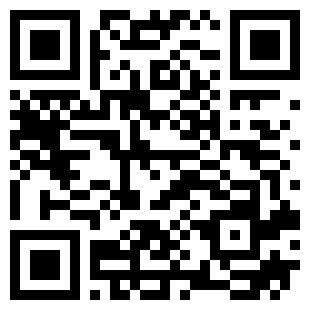

In [83]:
from IPython.display import Image

image_path = 'Img/QR_binary_gradio.png'
Image(filename=image_path)


In [82]:
### put my last binary image random forest regression here  ####


# Load the RF model


def get_pixel_count_gradio(input_img):
    # Add your implementation to calculate the pixel count from the input image
    pixel_count = 0  # Replace with your own code
    return pixel_count

def predict_head_circumference(input_img, pixel_size):
    # Use the pixel size and other features to make a prediction
    feature_names = ['pixel_count', 'pixel size(mm)']  # Add other relevant features here
    pixel_count = get_pixel_count_gradio(input_img)
    
    #prediction = rf_model.predict([[pixel_count, pixel_size]])[0]
    prediction = rf_model_a.predict([[pixel_count, pixel_size]])[0]

    
    return prediction

inputs = [
    gr.inputs.Image(label="Image"),
    gr.inputs.Number(label="Pixel Size (mm)")
]

output = gr.outputs.Textbox(label="Head Circumference (mm)")

rf_interface = gr.Interface(
    fn=predict_head_circumference,
    inputs=inputs,
    outputs=output,
    title="Head Circumference Predictor",
    description="Predicts the head circumference based on an image and pixel size.",
)

rf_interface.launch(share=True)

C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7873
Running on public URL: https://ddab7a3351f72a9623.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
#### ignore below

In [93]:
import gradio as gr

# Function to get head circumference from the filename
# def get_headcircum_from_filename(filename): - see box above
def get_headcircum_from_filename_gradio (filename):
    id = extract_id_from_filename(filename)
    print(id)
    row = RF_Output_df[RF_Output_df['id'] == id]
    headcircum = row['head circumference (mm)'].values[0] if not row.empty else None
    return id, headcircum


# Modify the predict function
def predict(image, filename):
    # Preprocess the input image
    preprocessed_image = preprocess_image(image)

    # Make the prediction using the model
    prediction = model.predict(preprocessed_image)[0]

    # Calculate the pixel count
    pixel_count = np.sum(prediction > 0.5)  # Adjust the threshold as needed

    # Get the head circumference from the filename
    headcircum = get_headcircum_from_filename(filename)

    # Return the predicted output, pixel count, and head circumference
    return prediction, pixel_count, headcircum

# Define the inputs and outputs
input_image = gr.inputs.Image(label="Input Image", type="pil")
output_image = gr.outputs.Image(label="Prediction", type="numpy")
output_pixel_count = gr.outputs.Label(label="Pixel Count")
output_headcircum = gr.outputs.Label(label="Head Circumference")
output_id = gr.outputs.Label(label="ID")

# Create the Gradio interface with a title
title = "HC Predictor 2"
gr.Interface(fn=get_headcircum_from_filename_gradio,  inputs=input_image, outputs=output_id )
#gr.Interface(fn=predict, inputs=input_image, outputs=[output_image, output_pixel_count, output_headcircum], title=title).launch()

gr.Interface()

TypeError: __init__() missing 3 required positional arguments: 'fn', 'inputs', and 'outputs'

In [ ]:
import gradio as gr

import numpy as np
from PIL import Image, ImageFilter



def preprocess_images(image):
    # Define the desired image dimensions for preprocessing
    dim = (224, 224)
    
    # Convert the input image to grayscale
    image_gray = image.convert('L')
    
    # Apply blur
    image_blurred = image_gray.filter(ImageFilter.BLUR)

    # Augmentation
    aug = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 3.0)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
        iaa.Affine(rotate=(-45, 45)),
        iaa.Multiply((0.8, 1.2))
    ])

    # Convert the augmented image to a tensor and resize it
    image_augmented = np.array(image_blurred)
    image_augmented = aug.augment_image(image_augmented)
    image_augmented = tf.convert_to_tensor(image_augmented)
    image_augmented = tf.expand_dims(image_augmented, -1)
    image_augmented = tf.image.resize_with_crop_or_pad(image_augmented, *dim)
    image_augmented = tf.cast(image_augmented, tf.float32) / 255.0

    return image_augmented

def predict(image):
    # Preprocess the input image
    preprocessed_image = preprocess_images(image)

    # Make the prediction
    prediction = model.predict(tf.expand_dims(preprocessed_image, axis=0))[0]

    # Return the predicted output
    return prediction

input_image = gr.inputs.Image(label="Input Image")
output_prediction = gr.outputs.Label(label="Prediction")

gr.Interface(fn=predict, inputs=input_image, outputs=output_prediction).launch()


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\helpers.py:637: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


1/1 [==============================] - 6s 6s/step


Traceback (most recent call last):
  File "C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\routes.py", line 394, in run_predict
    output = await app.get_blocks().process_api(
  File "C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\blocks.py", line 1075, in process_api
    result = await self.call_function(
  File "C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\blocks.py", line 884, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run(func, *args)

In [27]:
# Load the RF model
rf_model = joblib.load(rf_model_file)

In [29]:
import numpy as np
import gradio as gr
#import joblib

# Load the RF model
#rf_model = joblib.load("path/to/rf_model.joblib")

def get_pixel_count_gradio(input_img):
    # Add your implementation to calculate the pixel count from the input image
    pixel_count = 0  # Replace with your own code
    return pixel_count

def predict_head_circumference_b1(input_img, pixel_size):
    # Use the pixel size and other features to make a prediction
    feature_names = ['pixel_count', 'pixel size(mm)']  # Add other relevant features here
    pixel_count = get_pixel_count_gradio(input_img)
    
    prediction = rf_model.predict([[pixel_count, pixel_size]])[0]
    
    return prediction

inputs = [
    gr.inputs.Image(label="Image"),
    gr.inputs.Number(label="Pixel Size (mm)")
]

output = gr.outputs.Textbox(label="Head Circumference (mm)")

gr_interface = gr.Interface(
    fn=predict_head_circumference_b1,
    inputs=inputs,
    outputs=output,
    title="Head Circumference Predictor (binary image)",
    description="Predicts the head circumference based on an image and pixel size.",
)

gr_interface.launch(share=True)


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://d7fa423565ba291b59.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [40]:
def get_pixel_count_gradio(input_img):
    # Convert the input image to grayscale
    grayscale_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the pixel count by counting the non-zero pixels
    pixel_count = np.count_nonzero(grayscale_img)
    
    return pixel_count

def predict_head_circumference_b1(input_img, pixel_size):
    # Use the pixel size and other features to make a prediction
    feature_names = ['pixel_count', 'pixel size(mm)']  # Add other relevant features here
    pixel_count = get_pixel_count_gradio(input_img)
    
    prediction = rf_model.predict([[pixel_count, pixel_size]])[0]
    
    return prediction

inputs = [
    gr.inputs.Image(label="Image"),
    gr.inputs.Number(label="Pixel Size (mm)")
]

output = gr.outputs.Textbox(label="Head Circumference (mm)")

gr_interface = gr.Interface(
    fn=predict_head_circumference_b1,
    inputs=inputs,
    outputs=output,
    title="Head Circumference Predictor (Ultrasound image)",
    description="Predicts the head circumference based on an image and pixel size.",
)

gr_interface.launch(share=True)


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://418536eb638c3497af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [42]:
#Not working
def get_pixel_count_gradio(input_img):
    # Convert the input image to grayscale
    grayscale_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the pixel count by counting the non-zero pixels
    pixel_count = np.count_nonzero(grayscale_img)
    
    return pixel_count

def predict_head_circumference_us(input_img, pixel_size):
    # Use the pixel size and other features to make a prediction
    feature_names = ['pixel_count', 'pixel size(mm)', 'numpy']  # Add other relevant features here
    pixel_count = get_pixel_count_gradio(input_img)
    
    # Read the filename from the input image
    filename = input_img.name
    
    prediction = rf_model.predict([[pixel_count, pixel_size, filename]])[0]
    
    return prediction

inputs = [
    gr.inputs.Image(label="Image", type='numpy'),
    gr.inputs.Number(label="Pixel Size (mm)")
]

output = gr.outputs.Textbox(label="Head Circumference (mm)")

gr_interface = gr.Interface(
    fn=predict_head_circumference_b1,
    inputs=inputs,
    outputs=output,
    title="Head Circumference Predictor",
    description="Predicts the head circumference based on an image and pixel size.",
)

gr_interface.launch(share=True)



C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://3bc0b762991056740a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [25]:
# Function to retrieve head circumference based on ID
def get_head_circumference(id, image):
    try:
        # Find the row with the given ID
        row = df[df['ID'] == id]
        # Retrieve the head circumference value
        head_circumference = row['Head Circumference'].values[0]
        return f"Head Circumference for ID {id}: {head_circumference} cm"
    except:
        return "Invalid ID"

# Create a Gradio interface
iface = gr.Interface(
    fn=get_head_circumference,
    inputs=["text", "image"],
    outputs="text",
    title="Head Circumference Lookup",
    description="Enter an ID and upload an image to retrieve the corresponding head circumference",
    examples=[['ID123', 'path/to/image.jpg']],
    allow_flagging=False
)

# Launch the Gradio app
iface.launch()


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/image.jpg'

In [24]:
# Function to retrieve head circumference based on ID
def get_head_circumference(id, image):
    try:
        # Find the row with the given ID
        row = df[df['ID'] == id]
        # Retrieve the head circumference value
        head_circumference = row['Head Circumference'].values[0]
        return f"Head Circumference for ID {id}: {head_circumference} cm"
    except:
        return "Invalid ID"

# Create a Gradio interface
iface = gr.Interface(
    fn=get_head_circumference,
    inputs=["text", "image"],
    outputs="text",
    title="Head Circumference Lookup",
    description="Enter an ID and upload an image to retrieve the corresponding head circumference",
    examples=[['ID123', 'path/to/image.jpg']],
    allow_flagging=False
)

# Launch the Gradio app
iface.launch()


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\interface.py:333: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/image.jpg'

In [22]:
#import os
#import gradio as gr
#import pandas as pd

# Function to retrieve head circumference based on ID
def get_head_circumference_gradio2(filename, image):
    try:
        # Extract the ID from the filename
        id = os.path.splitext(filename)[0]
        print(id)
        
        # Find the row with the extracted ID
        row = df[df['ID'] == id]
        
        # Retrieve the head circumference value
        head_circumference = row['Head Circumference'].values[0]
        
        return f"Head Circumference for ID {id}: {head_circumference} cm"
    except:
        return "Invalid ID"

# Create a Gradio interface
iface = gr.Interface(
    fn=get_head_circumference_gradio2,
    inputs=["text", "image"],
    outputs="text",
    title="Head Circumference Lookup",
    description="Enter a filename and upload an image to retrieve the corresponding head circumference",
    # examples=[['086_HC.png', 'path/to/image.jpg']],
    allow_flagging=False
)

# Launch the Gradio app
iface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


050_






In [20]:
####  ignore below ####

In [19]:
unet_model_path="toIgnore/Modelfile_large/unet_custom.hdf5"
os.path.exists(unet_model_path)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 24-25: truncated \uXXXX escape (1061346694.py, line 1)

In [18]:
model = tf.keras.models.load_model("unet_model_path")

OSError: No file or directory found at unet_model_path

In [12]:
from utils_unet_a.py import *

ModuleNotFoundError: No module named 'imgaug'

In [11]:
import gradio as gr
import tensorflow as tf
import cv2
import numpy as np

# Load the UNet model
model = tf.keras.models.load_model("unet_custom.hdf5")

# Define the image segmentation function
def segment_head_circumference(image):
    # Preprocess the input image
    processed_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    processed_image = processed_image / 255.0
    processed_image = np.expand_dims(processed_image, axis=0)
    processed_image = np.expand_dims(processed_image, axis=-1)

    # Perform the segmentation
    prediction = model.predict(processed_image)
    prediction = np.squeeze(prediction)
    binary_image = np.where(prediction > 0.5, 255, 0).astype(np.uint8)

    return binary_image

# Define the input and output interfaces for Gradio
inputs = gr.inputs.Image(label="Ultrasound Image (PNG format)")
output = gr.outputs.Image(label="Segmented Head Circumference")

# Create the Gradio interface
gr_interface = gr.Interface(
    fn=segment_head_circumference,
    inputs=inputs,
    outputs=output,
    title="Ultrasound Image Segmentation",
    description="Segment the head circumference in ultrasound images.",
)

# Run the Gradio app on the Hugging Face Spaces platform
gr_interface.launch()


ValueError: Unknown loss function: bce_dice_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [2]:
g_path_to = 'G:/.shortcut-targets-by-id/10wVB-YsfTmmpZyUo8jBH1cDOkVWVx5N1/T1 Project/Data/'
os.path.exists(g_path_to)

True

In [3]:
path_to = 'Data/Training-Splitted'
os.path.exists(path_to)


True

In [4]:
pred_img2_path_to = 'Data/predicted_images2'
os.path.exists(pred_img2_path_to)

False

In [5]:
files = os.listdir(path_to)

In [6]:
model_path_to = 'Modelfile/'
os.path.exists(model_path_to)

True

In [7]:
rf_model_joblib_name = 'pixelCt_pixelSz_toHeadCir_rfReg.joblib'
rf_model_joblib_file = model_path_to+rf_model_joblib_name  
os.path.exists(rf_model_joblib_file)

True

In [8]:
rf_model_joblib_file

'Modelfile/pixelCt_pixelSz_toHeadCir_rfReg.joblib'

In [9]:
#import joblib

# Load the trained Random Forest model
rf_model = joblib.load(rf_model_joblib_file)

# to use rf_model.predict(input_data)   #input_data has column of feature_names = ['pixel_count','pixel size(mm)']
feature_names = ['pixel_count','pixel size(mm)']

# X = input_dffeature_names]
# y_pred  = rf_model.predict(X)

In [10]:
##### function get_pixe_count get_pixel_count(img_data_path, filename) ###  duplicate code from above.
def get_pixel_count(img_data_path, filename):
    file_path = os.path.join(img_data_path, filename)
    if os.path.exists(file_path):
        label = Image.open(file_path)
        label = np.array(label)
        label = tf.convert_to_tensor(label)
        label = tf.cast(label, tf.float32) / 255.0
        label = tf.cast(label, tf.int32)
        pixel_count = np.sum(label)
    else:
        print("No such file: " + filename)
        pixel_count = np.nan

    return pixel_count


In [96]:
### get_pixel_count_gradio demo ###
import numpy as np
import gradio as gr

def get_pixel_count_gradio(input_img):
    label = np.array(input_img)
    label = tf.convert_to_tensor(label)
    label = tf.cast(label, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    pixel_count = np.sum(label)
    print(pixel_count)
    return pixel_count

demo = gr.Interface(
    fn=get_pixel_count_gradio,
    inputs=gr.inputs.Image(shape=(800, 540)),
    outputs="number"
)

#demo.launch(share=True)
demo.launch()



C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7877

To create a public link, set `share=True` in `launch()`.


In [12]:
import numpy as np
import gradio as gr
import joblib

# Load the RF model
#rf_model = joblib.load("rf_model_joblib_file")

### get_pixel_count_gradio demo ###
def get_pixel_count_gradio(input_img):
    label = np.array(input_img)
    pixel_count = np.sum(label)
    print(pixel_count)
    return pixel_count

demo = gr.Interface(
    fn=get_pixel_count_gradio,
    inputs=gr.inputs.Image(shape=(800, 540)),
    outputs="number"
)

demo.launch()

def predict_head_circumference(input_img, pixel_size):
    # Use the pixel size and other features to make a prediction
    feature_names = ['pixel_count', 'pixel size(mm)']  # Add other relevant features here
    pixel_count = get_pixel_count_gradio(input_img)
    
    prediction = rf_model.predict([[pixel_count, pixel_size]])[0]
    print(prediction)
    
    return prediction

inputs = [
    gr.inputs.Image(label="Image"),
    gr.inputs.Number(label="Pixel Size (mm)")
]

output = gr.outputs.Textbox(label="Head Circumference (mm)")

gr_interface = gr.Interface(
    fn=predict_head_circumference,
    inputs=inputs,
    outputs=output,
    title="Head Circumference Predictor",
    description="Predicts the head circumference based on an image and pixel size.",
)

gr_interface.launch()


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [13]:





















#import gradio as gr
#import pandas as pd
#import joblib
#import cv2

# Load the RF model
rf_model = joblib.load(rf_model_joblib_file)

# Load the CSV file with pixel size data
#csv_file_path = 'pixel_size_data.csv'
#pixel_size_data = pd.read_csv(csv_file_path)

def predict_head_circumference(input_img, pixel_size):
    # Process the image (e.g., resize, normalize, etc.)
    #processed_image = preprocess_image(image)  #image already in binary form
    
    # Use the pixel size and other features to make a prediction
    feature_names = ['pixel_count','pixel size(mm)']  # Add other relevant features here
    pixel_count = get_pixel_count_gradio(input_img)
    pixel_size = pixel_size
    
    prediction = rf_model.predict([pixel_count,pixel_size])[0]
    print(prediction)
    
    return prediction

#def preprocess_image(image):
#    # Preprocess the image (e.g., resize, normalize, etc.)
#    # Modify this function based on your specific image preprocessing requirements
#    processed_image = cv2.resize(image, (224, 224))
#    processed_image = processed_image / 255.0  # Normalize pixel values
    
#    return processed_image

# Define the input and output interfaces for Gradio
inputs = [
    gr.inputs.Image(label="Image"),
    gr.inputs.Number(label="Pixel Size (mm)")
]

output = gr.outputs.Textbox(label="Head Circumference (mm)")

# Create the Gradio interface
gr_interface = gr.Interface(
    fn=predict_head_circumference,
    inputs=inputs,
    outputs=output,
    title="Head Circumference Predictor",
    description="Predicts the head circumference based on an image and pixel size.",
)

# Run the Gradio app
gr_interface.launch()


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


In [14]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(
    fn=greet,
    inputs=gr.Textbox(lines=2, placeholder="Name Here..."),
    #outputs="text",
    outputs=gr.outputs.Textbox(label="Prediction")
)
demo.launch()




C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In [95]:
import numpy as np
import gradio as gr

def sepia(input_img):
    sepia_filter = np.array([
        [0.393, 0.769, 0.189], 
        [0.349, 0.686, 0.168], 
        [0.272, 0.534, 0.131]
    ])
    sepia_img = input_img.dot(sepia_filter.T)
    sepia_img /= sepia_img.max()
    return sepia_img

demo = gr.Interface(sepia, gr.Image(shape=(200, 200)), "image")
demo.launch()


Running on local URL:  http://127.0.0.1:7876

To create a public link, set `share=True` in `launch()`.


In [16]:







# Get the input shape
input_shape = image.size

print("Input shape:", input_shape)


NameError: name 'image' is not defined

3603150
137.53759999999988


C:\Users\annch\.conda\envs\unet-py39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
